In [1]:
import pyvips
import pandas as pd
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf
import torch
import albumentations as A

import sys
sys.path.append("../")
from src.generators.foundation_models import FOUNDATION_MODEL_REGISTRY
from src.dataset import TileSlideDataset, NormalizationLayer

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
mean, std = np.asarray([0.707223, 0.578729, 0.703617])*255, np.asarray([0.211883, 0.230117, 0.177517])*255

preprocess_input_fn = NormalizationLayer({"mean": mean, "std": std})

he [[180.341865 147.575895 179.422335]] [[54.030165 58.679835 45.266835]]


## Hemit

In [ ]:
data_cfg = OmegaConf.load("/root/workdir/AIDA-ImagetoImageHE2IF/configs/data/hemit.yaml")

In [ ]:
train_dataframe = pd.read_csv(data_cfg.data.train_dataframe_path).sample(500)
val_dataframe = pd.read_csv(data_cfg.data.val_dataframe_path).sample(500)
test_dataframe = pd.read_csv(data_cfg.data.test_dataframe_path).sample(500)

In [ ]:
torch.cuda.empty_cache()

model = FOUNDATION_MODEL_REGISTRY["hoptimus0"](
    img_size=512, ckpt_path="/root/workdir/foundation_models/hoptimus0.bin", global_pool="token").eval().cuda().half()

In [ ]:
train_dataset = TileSlideDataset(train_dataframe, preprocess_input_fn=preprocess_input_fn)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=6)

val_dataset = TileSlideDataset(val_dataframe, preprocess_input_fn=preprocess_input_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=6)

test_dataset = TileSlideDataset(test_dataframe, preprocess_input_fn=preprocess_input_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=6)

In [ ]:
train_features_hemit = []
for batch in tqdm(train_dataloader, total=len(train_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    train_features_hemit.append(features_batch)
train_features_hemit = torch.vstack(train_features_hemit).numpy()

val_features_hemit = []
for batch in tqdm(val_dataloader, total=len(val_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    val_features_hemit.append(features_batch)
val_features_hemit = torch.vstack(val_features_hemit).numpy()

test_features_hemit = []
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    test_features_hemit.append(features_batch)
test_features_hemit = torch.vstack(test_features_hemit).numpy()

100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


## Orion

In [ ]:
data_cfg = OmegaConf.load("/root/workdir/AIDA-ImagetoImageHE2IF/configs/data/orion.yaml")

In [ ]:
train_dataframe = pd.read_csv(data_cfg.data.train_dataframe_path).sample(500)
val_dataframe = pd.read_csv(data_cfg.data.val_dataframe_path).sample(500)
test_dataframe = pd.read_csv(data_cfg.data.test_dataframe_path).sample(500)
dataframe = pd.concat([train_dataframe, val_dataframe, test_dataframe])

In [ ]:
torch.cuda.empty_cache()

model = FOUNDATION_MODEL_REGISTRY["hoptimus0"](
    img_size=256, ckpt_path="/root/workdir/foundation_models/hoptimus0.bin", global_pool="token").eval().cuda().half()

In [ ]:
spatial_augmentation = A.CenterCrop(256, 256)

dataset = TileSlideDataset(dataframe, preprocess_input_fn=preprocess_input_fn,
                                 spatial_augmentations=spatial_augmentation)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=6)

In [ ]:
features_orion = []
for batch in tqdm(dataloader, total=len(dataloader)):
    x = batch["image"]
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    features_orion.append(features_batch)
features_orion = torch.vstack(features_orion).numpy()

100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


In [ ]:
from pathlib import Path
augmentation_dir = "/root/workdir/tile_orion_norm_slides"
train_dataframe["image_path"] = train_dataframe["image_path"].apply(lambda x: str(Path(augmentation_dir) / Path(x).name))
dataset = TileSlideDataset(train_dataframe, preprocess_input_fn=preprocess_input_fn,
                                 spatial_augmentations=spatial_augmentation)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=6)

In [14]:
features_orion_cyclegan = []
for batch in tqdm(dataloader, total=len(dataloader)):
    x = batch["image"]
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    features_orion_cyclegan.append(features_batch)
features_orion_cyclegan = torch.vstack(features_orion_cyclegan).numpy()

100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


## IMMUcan

In [15]:
data_cfg = OmegaConf.load("/root/workdir/AIDA-ImagetoImageHE2IF/configs/data/immucan.yaml")

In [16]:
dataframe = pd.read_csv(data_cfg.data.test_dataframe_path).sample(1500)

In [17]:
torch.cuda.empty_cache()

model = FOUNDATION_MODEL_REGISTRY["hoptimus0"](
    img_size=1024, ckpt_path="/root/workdir/foundation_models/hoptimus0.bin", global_pool="token").eval().cuda().half()

In [18]:
dataset = TileSlideDataset(dataframe, preprocess_input_fn=preprocess_input_fn)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=6)

In [19]:
features_immucan = []
for batch in tqdm(dataloader, total=len(dataloader)):
    x = batch["image"]
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    features_immucan.append(features_batch)
features_immucan = torch.vstack(features_immucan).numpy()

100%|██████████| 94/94 [08:22<00:00,  5.35s/it]


## Umap

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


array([[0.79238784]], dtype=float32)

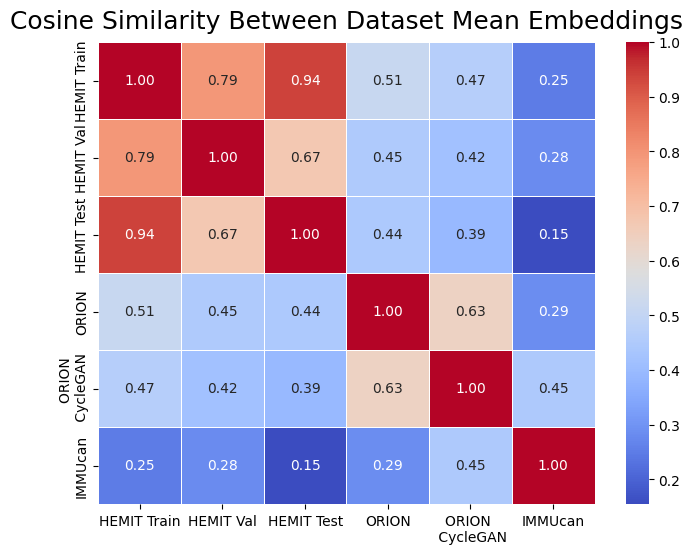

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def compute_cosine_similarity(X, Y):
    mean_X = X.mean(axis=0, keepdims=True)
    mean_Y = Y.mean(axis=0, keepdims=True)
    cosine_sim = cosine_similarity(mean_X, mean_Y).item()
    return cosine_sim


data_dict = {
    "HEMIT Train": train_features_hemit,
    "HEMIT Val": val_features_hemit,
    "HEMIT Test": test_features_hemit,
    "ORION": features_orion,
    "ORION \n CycleGAN": features_orion_cyclegan,
    "IMMUcan": features_immucan

}

dataset_names = list(data_dict.keys())

# Compute cosine similarity matrix
similarity_matrix = np.zeros((len(dataset_names), len(dataset_names)))
for i, dataset_name_i in enumerate(dataset_names):
    for j, dataset_name_j in enumerate(dataset_names):
        cosine_sim = compute_cosine_similarity(data_dict[dataset_name_i], data_dict[dataset_name_j])
        similarity_matrix[i, j] = cosine_sim

# Convert to DataFrame for visualization
df_similarity = pd.DataFrame(similarity_matrix, index=dataset_names, columns=dataset_names)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_similarity, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cosine Similarity Between Dataset Mean Embeddings", fontsize=18, pad=10)
plt.show()

In [59]:
embeddings_list = [train_features_hemit, val_features_hemit, test_features_hemit, features_orion, features_orion_cyclegan, features_immucan]
label_list = ["Train HEMIT", "Val HEMIT", "Test HEMIT", "ORION", "ORION->IMMUcan CycleGAN", "IMMUcan"]

embeddings = []
labels = []
for embeddings_curr, label in zip(embeddings_list, label_list):
    embeddings.append(embeddings_curr)
    labels.extend([label] * len(embeddings_curr))

embeddings = np.vstack(embeddings)
labels = np.asarray(labels)

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


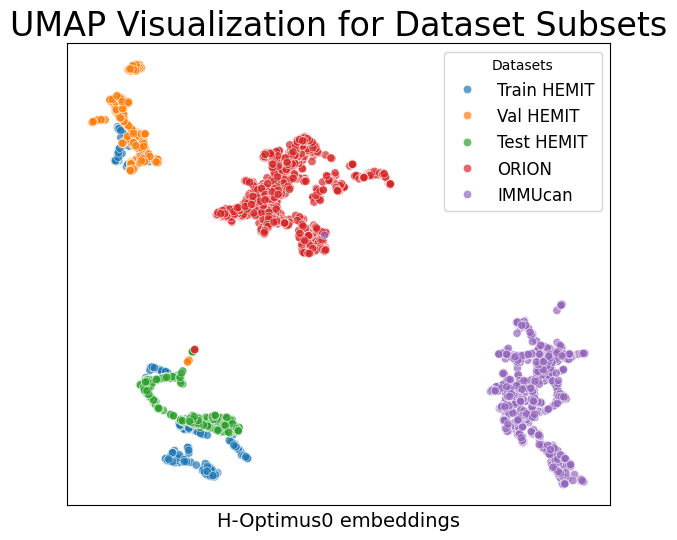

In [60]:
import seaborn as sns
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "UMAP-1": embedding_2d[:, 0],
    "UMAP-2": embedding_2d[:, 1],
    "Label": labels
})

# Plot using seaborn
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df[~(df["Label"] == "ORION->IMMUcan CycleGAN")], x="UMAP-1", y="UMAP-2", hue="Label", palette="tab10", alpha=0.7, edgecolor="w")

# Labels and title
plt.title("UMAP Visualization for Dataset Subsets", fontsize=24)
plt.legend(title="Datasets", fontsize=12)

plt.xticks([])
plt.yticks([])
plt.xlabel("H-Optimus0 embeddings", fontsize=14)
plt.ylabel("")
#plt.savefig("/root/workdir/umap.svg", format="svg", bbox_inches="tight")
#plt.savefig("/root/workdir/umap.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

## Hemit domains

In [3]:
data_cfg = OmegaConf.load("/root/workdir/AIDA-ImagetoImageHE2IF/configs/data/hemit.yaml")
train_dataframe = pd.read_csv(data_cfg.data.train_dataframe_path)
val_dataframe = pd.read_csv(data_cfg.data.val_dataframe_path)
test_dataframe = pd.read_csv(data_cfg.data.test_dataframe_path)
torch.cuda.empty_cache()

model = FOUNDATION_MODEL_REGISTRY["hoptimus0"](
    img_size=512, ckpt_path="/root/workdir/foundation_models/hoptimus0.bin", global_pool="token").eval().cuda().half()
train_dataset = TileSlideDataset(train_dataframe, preprocess_input_fn=preprocess_input_fn)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=6)

val_dataset = TileSlideDataset(val_dataframe, preprocess_input_fn=preprocess_input_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=6)

test_dataset = TileSlideDataset(test_dataframe, preprocess_input_fn=preprocess_input_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=6)
train_features_hemit = []
for batch in tqdm(train_dataloader, total=len(train_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    train_features_hemit.append(features_batch)
train_features_hemit = torch.vstack(train_features_hemit).numpy()

val_features_hemit = []
for batch in tqdm(val_dataloader, total=len(val_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    val_features_hemit.append(features_batch)
val_features_hemit = torch.vstack(val_features_hemit).numpy()

test_features_hemit = []
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    x = torch.nn.functional.interpolate(batch["image"], (512, 512), mode="bilinear")
    with torch.inference_mode():
        features_batch = model(x.cuda().half()).float().cpu()
    test_features_hemit.append(features_batch)
test_features_hemit = torch.vstack(test_features_hemit).numpy()

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [29]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_sim_train_val = cosine_similarity(train_features_hemit, val_features_hemit).max(axis=1, keepdims=True)
cosine_sim_train_test = cosine_similarity(train_features_hemit, test_features_hemit).max(axis=1, keepdims=True)
cosine_sim_train = np.hstack((cosine_sim_train_val, cosine_sim_train_test))

label_centers = cosine_sim_train.argmax(axis=1)
label_centers[cosine_sim_train.max(axis=1) < 0.75] = 2

In [30]:
(label_centers == 2).mean()

np.float64(0.15523271455474846)

In [82]:
from sklearn.linear_model import LogisticRegression
X_train = np.vstack((val_features_hemit, test_features_hemit))
y_train = np.zeros(len(X_train), dtype=bool)
y_train[:len(val_features_hemit)] = True

model = LogisticRegression(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_train_pred = model.predict(train_features_hemit)
print((y_pred == y_train).mean())
print(np.mean(y_train_pred == 1))

1.0
0.2206080172181867


In [73]:
embeddings_list = [train_features_hemit, val_features_hemit, test_features_hemit, features_orion, features_immucan]
label_list = ["Train HEMIT", "Val HEMIT", "Test HEMIT", "ORION", "IMMUcan"]

embeddings = []
labels = []
for embeddings_curr, label in zip(embeddings_list, label_list):
    embeddings.append(embeddings_curr)
    labels.extend([label] * len(embeddings_curr))

embeddings = np.vstack(embeddings)
labels = np.asarray(labels)

embedding_2d = reducer.fit_transform(embeddings)

NameError: name 'reducer' is not defined

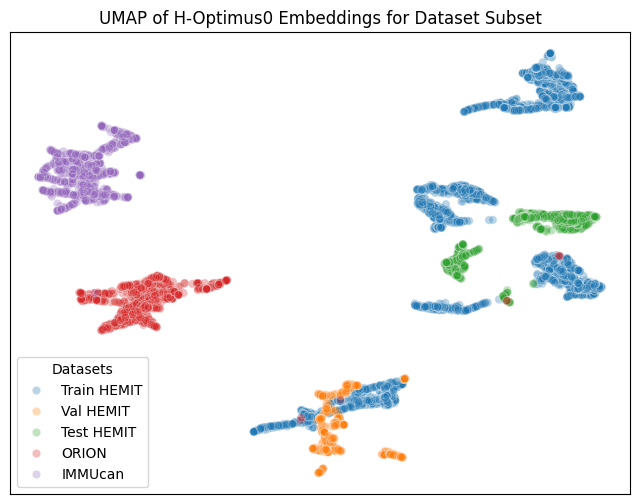

In [66]:
df = pd.DataFrame({
    "UMAP-1": embedding_2d[:, 0],
    "UMAP-2": embedding_2d[:, 1],
    "Label": labels
})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="UMAP-1", y="UMAP-2", hue="Label", palette="tab10", alpha=0.3, edgecolor="w")

# Labels and title
plt.title("UMAP of H-Optimus0 Embeddings for Dataset Subset")
plt.legend(title="Datasets")

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()

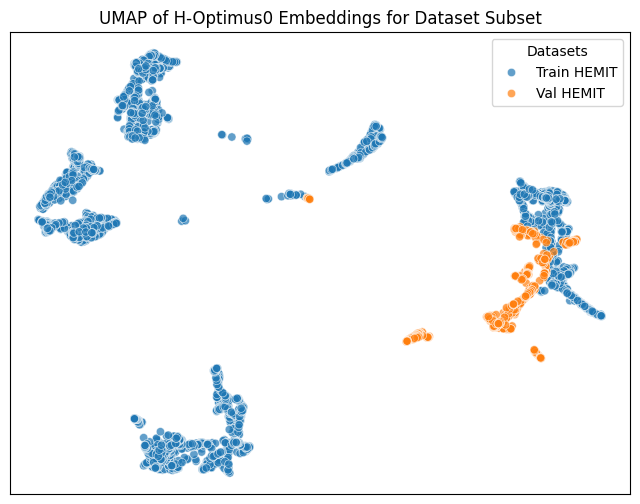

In [45]:
df = pd.DataFrame({
    "UMAP-1": embedding_2d[:, 0],
    "UMAP-2": embedding_2d[:, 1],
    "Label": labels
})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df[df["Label"].isin(["Train HEMIT", "Val HEMIT"])], x="UMAP-1", y="UMAP-2", hue="Label", palette="tab10", alpha=0.7, edgecolor="w")

# Labels and title
plt.title("UMAP of H-Optimus0 Embeddings for Dataset Subset")
plt.legend(title="Datasets")

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.show()